# Let's install some of the dependencies at first

In [ ]:
# !pip install opencv-python
# !pip install sklearn
# !pip install shutil

# Importing libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
import glob
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from IPython.display import clear_output
import shutil
import os
from PIL import Image as PImage
from matplotlib import pyplot as plt

# Preparing the model using ResNet50 network pre-trained on ImageNet dataset

In [3]:
model = tf.keras.Sequential()
model.add(ResNet50(include_top=False, weights='imagenet'))
model.layers[0].trainable = False

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


# Extract vectors representing the images from the model

In [5]:
def extract_vector(path):
    full_path = path + '*'
    resnet_feature_list = []
    id = 0
    id_to_pic = {}
    for im in glob.glob(full_path):
        id_to_pic[id]=im.replace(path, '')
        im = PImage.open(im)
        im = im.resize((224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())
        id += 1

    return id_to_pic, np.array(resnet_feature_list)

In [6]:
base_path = 'Test_Pics/'
id_to_pic, feat_set = extract_vector(base_path)
print('{} pics loaded...'.format(len(id_to_pic)))
print(id_to_pic)

6 pics loaded...
{0: 'rat3.jpeg', 1: 'dog2.jpg', 2: 'dog1.jpeg', 3: 'dog3.jpeg', 4: 'rat2.jpg', 5: 'rat1.jpeg'}


# Select the most appropriate number of clusters based on the elbow rule

In [7]:
min_cluster = 1
max_cluster = len(id_to_pic)
sum_of_squared_distances = []
idx_to_cluster = {}
K = range(min_cluster, max_cluster+1)
count = 0
for k in K:
    idx_to_cluster[count] = k
    kmeans = KMeans(n_clusters=k, random_state=0).fit(feat_set)
    sum_of_squared_distances.append(kmeans.inertia_)
    count += 1
sum_of_squared_distances = minmax_scale(sum_of_squared_distances, feature_range=(0, 1), axis=0, copy=True)

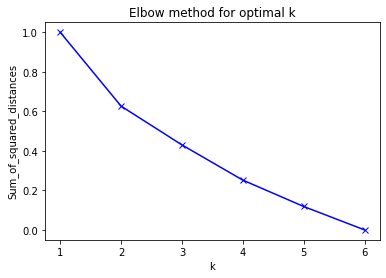

In [8]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [9]:
num_cluster_options = len(sum_of_squared_distances)
delta1 = [-1] * num_cluster_options
delta2 = [-1] * num_cluster_options
strength = [-1] * num_cluster_options
relative_strength = [-1] * num_cluster_options
for idx in range(1, num_cluster_options):
    delta1[idx] = sum_of_squared_distances[idx] - sum_of_squared_distances[idx-1]
for idx in range(2,num_cluster_options):
    delta2[idx] = delta1[idx] - delta1[idx-1]
for idx in range(1, num_cluster_options-1):
    strength[idx] = delta2[idx+1] - delta1[idx-1]
    relative_strength[idx] = strength[idx]/idx_to_cluster[idx]
print(relative_strength)
optimal_cluster_count = idx_to_cluster[np.argmax(relative_strength)]
print('Optimal number of clusters: {}'.format(optimal_cluster_count))

[-1, 0.5886887077605414, 0.13061030553455136, 0.06024632014612032, 0.03859652826149236, -1]
Optimal number of clusters: 2


# Perform KMeans with the optimal number of clusters



In [10]:
kmeans = KMeans(n_clusters=optimal_cluster_count, random_state=0).fit(feat_set)
labels = kmeans.labels_
for id in range(len(labels)):
    print('{} : {}'.format(id_to_pic[id], labels[id]))

rat3.jpeg : 1
dog2.jpg : 0
dog1.jpeg : 0
dog3.jpeg : 0
rat2.jpg : 0
rat1.jpeg : 0


# Create the necessary folders and label the classes appropriately

In [12]:
dataset_name = 'Dogs vs Cats'
pics_to_show = 3
if not os.path.exists(dataset_name):
    os.mkdir(dataset_name)
classes = np.unique(labels)
class_names = {}
for cur_class in classes:
    pic_id = np.where(labels==cur_class)[0][0:pics_to_show]
    fig, axes = plt.subplots(1,pics_to_show)
    count = 0
    for pic_idx in pic_id:
        file_path = base_path + id_to_pic[pic_idx]
        img = PImage.open(file_path)
        img = img.resize((224,224))
        axes[count].imshow(img)
        axes[count].xaxis.set_visible(False)
        axes[count].yaxis.set_visible(False)
        count += 1
    plt.show(fig)
    class_names[cur_class] = input('Name of the class: ')
    clear_output()
    class_dir_path = dataset_name + '/' + class_names[cur_class]
    if not os.path.exists(class_dir_path):
        os.mkdir(class_dir_path)

In [ ]:
for cur_class in classes:
    for id in range(len(labels)):
        if(labels[id] == cur_class):
            img_src = base_path + id_to_pic[id]
            img_dest = dataset_name + '/' + class_names[cur_class] + '/' + img_src.replace(base_path,'')
            shutil.copyfile(img_src, img_dest)